In [10]:
import os
import pandas as pd
import numpy as np
from typing import Union, List, Literal
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [190]:
from Helper_Util import *

In [2]:
Filepath = '/content/drive/MyDrive/QoS Prediction Challenge by ITU ML in 5G Challenge'
pd.set_option('display.max_colwidth',200)

In [3]:
def Load_Data(file_path: str) -> List[pd.DataFrame]:
  train = pd.read_csv(file_path+'/Train.csv')
  test = pd.read_csv(file_path+'/Test.csv')
  sub = pd.read_csv(file_path+'/SampleSubmission.csv')
  variables = pd.read_csv(file_path+'/VariableDefinitions.csv')

  return train, test, sub, variables


In [4]:
Train, Test, Sub, Variables = Load_Data(Filepath)

### Data Exploration

In [28]:
Train.head(3)

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
0,Id_qt2qn56050,1624367008,pc1,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,Residential,51500000.0
1,Id_f1zf07cwb6,1624372465,pc3,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,Residential,50300000.0
2,Id_uoxdz7di5b,1624371871,pc3,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,Residential,16500000.0


In [29]:
Test.head(3)

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area
0,Id_ln0e0hfrgx,1624374179,pc2,-97.121875,-12.923750,-87.554375,13.293,39276.0,24.0,20,...,23.05,14.55,0.59,1013.6,2.27,0.83,3.0,16.093,3.07702,Avenue
1,Id_svf7nz9fxv,1624366264,pc4,-65.202500,-9.944375,-35.501875,21.823,39566.0,25.0,20,...,21.56,13.92,0.62,1013.6,2.42,0.95,4.0,16.093,0.66000,Park
2,Id_ww2mh07gwj,1624375795,pc2,-79.298125,-17.468750,-74.823750,24.114,41900.0,27.0,20,...,22.93,14.65,0.60,1013.5,2.26,0.85,3.0,16.093,2.49330,Park


In [30]:
Train.select_dtypes(include=['object']).columns
Test.select_dtypes(include=['object']).columns

Index(['id', 'device', 'area'], dtype='object')

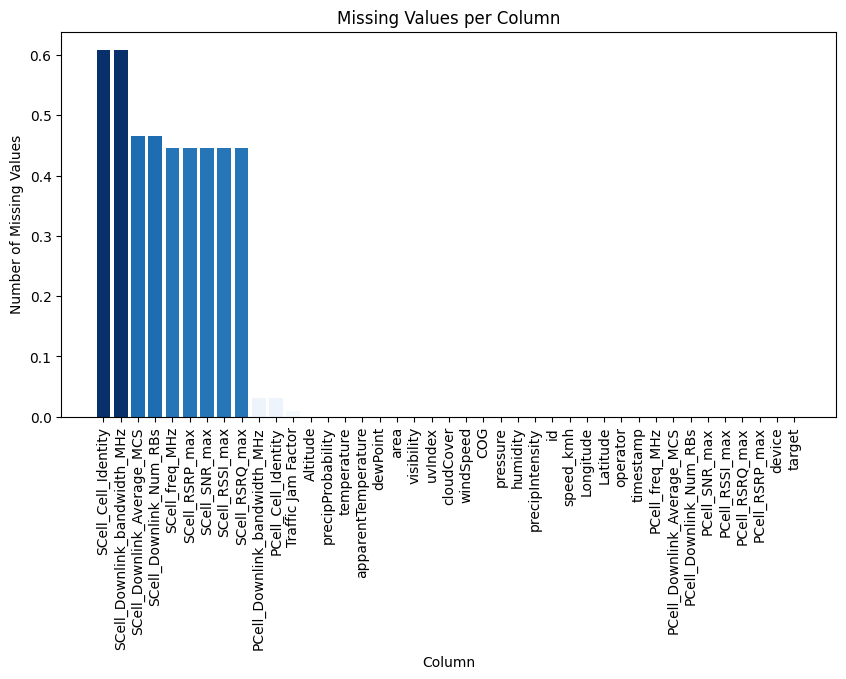

In [73]:
missing_values = Train.isna().sum()/ Train.shape[0]
missing_values = missing_values.sort_values(ascending=False)


# Normalize the data to be between 0 and 1
norm = plt.Normalize(missing_values.values.min(), missing_values.values.max())
# Create a colormap
cmap = cm.ScalarMappable(norm=norm, cmap='Blues')
# Generate colors for each bar
colors = [cmap.to_rgba(val) for val in missing_values.values]

# Create bar plot of missing values
plt.figure(figsize=(10,5))
plt.bar(missing_values.index, missing_values.values, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Column')
plt.show()



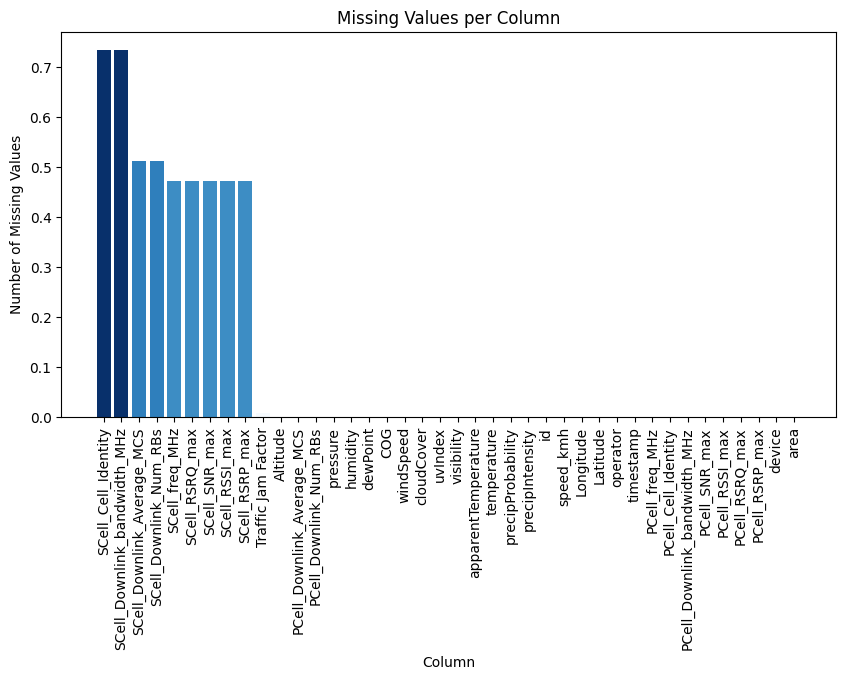

In [69]:
missing_values = Test.isna().sum()/ Test.shape[0]
missing_values = missing_values.sort_values(ascending=False)
import matplotlib.cm as cm

# Normalize the data to be between 0 and 1
norm = plt.Normalize(missing_values.values.min(), missing_values.values.max())
# Create a colormap
cmap = cm.ScalarMappable(norm=norm, cmap='Blues')
# Generate colors for each bar
colors = [cmap.to_rgba(val) for val in missing_values.values]

# Create bar plot of missing values
plt.figure(figsize=(10,5))
plt.bar(missing_values.index, missing_values.values, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Column')
plt.show()

SCELLS_ have the most missing values

###Baseline Score

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from abc import ABC, abstractmethod
import random

In [6]:
!pip install catboost -q
from catboost import CatBoostRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.0 MB/s eta 0:00:00


In [86]:
Sscaler = StandardScaler()
Mmscaler = MinMaxScaler()
lr = LinearRegression()
xgb = XGBRegressor()
cbc = CatBoostRegressor()
lgb = LGBMRegressor()
mse = mean_squared_error

In [208]:
class Baseline_score():
  def __init__(
      self,
      train: pd.DataFrame,
      model: Union[XGBRegressor, LGBMRegressor, CatBoostRegressor,LinearRegression],
      scaler: Union[StandardScaler, MinMaxScaler, None] = None,
      split_method: Literal["KFold", "train_test_split"] = "KFold",
      num_split = 5,
      random_seed = 42,
      VERBOSE: Literal[True,False] = False
  ):
    if not isinstance(model, (XGBRegressor, LGBMRegressor, CatBoostRegressor,LinearRegression)):
      raise TypeError("model must be a class of either XGBRegressor, LGBMRegressor, CatBoostRegressor, or LinearRegression")
    if scaler is not None and not isinstance(scaler, (StandardScaler, MinMaxScaler)):
        raise TypeError("scaler must be a class of either StandardScaler, MinMaxScaler or None")
    if not isinstance(train, pd.DataFrame):
      raise TypeError("train must be a DataFrame")

    self.train = train
    self.model = model
    self.scaler = scaler
    self.split = split_method
    self.num_split = num_split
    self.seed = random_seed
    self.VERBOSE = VERBOSE
    self.feature_importances = None
    random.seed(random_seed)
    np.random.seed(random_seed)

  def run(self)-> float:
    X = self.train.iloc[:,:-1]
    self.feature_importances = np.zeros(X.shape[1])
    y = self.train.iloc[:,-1]

    if self.split == "train_test_split":
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=self.seed)
      if self.scaler != None:
        X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)
      self.model.fit(X_train, y_train)
      self.feature_importances += self.model.feature_importances_
      preds = self.model.predict(X_test)
      print(f"split: {(self.split).upper()}")
      print(f"RMSE {mean_squared_error(y_test,preds,squared=False)}")
      print(f"MAE {mean_absolute_error(y_test,preds)}")
      print(f"MSE {mean_squared_error(y_test,preds)}")
      score = mean_squared_error(y_test,preds,squared=False)
      return score

    else:
      fold = KFold(n_splits=self.num_split)
      oof_f1 = []
      i = 1
      for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index],X.iloc[test_index]
        y_train, y_test = y.iloc[train_index],y.iloc[test_index]
        if self.scaler != None:
          X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)
        if isinstance(self.model, CatBoostRegressor):
          self.model.fit(X_train,y_train,verbose=False)
        else:
          self.model.fit(X_train,y_train)
        self.feature_importances += self.model.feature_importances_
        preds=self.model.predict(X_test)
        if self.VERBOSE:
          print(f"split {self.split}{i}")
          print(f"RMSE {mean_squared_error(y_test,preds,squared=False)}")
          print(f"MAE {mean_absolute_error(y_test,preds)}")
          print(f"MSE {mean_squared_error(y_test,preds)}\n")
        oof_f1.append(mean_squared_error(y_test,preds,squared=False))
        i += 1

      self.feature_importances = self.feature_importances / self.num_split
      score = sum(oof_f1)/self.num_split
      return score

  def plot_features(self):
    X = self.train.iloc[:,:-1]
    features = pd.DataFrame({'feature': list(X.columns),
                             'importance': self.feature_importances}).sort_values('importance', ascending = True)
    norm = plt.Normalize(features['importance'].min(), features['importance'].max())
    cmap = cm.ScalarMappable(norm=norm, cmap='Reds')
    colors = [cmap.to_rgba(val) for val in features['importance'].values]
    plt.figure(figsize=(25,10))
    plt.barh(features['feature'],features['importance'], color=colors)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.show()




In [159]:
TT = Train.drop(['id','timestamp'],axis=1)
TT['device'] = TT['device'].map({'pc1':1,'pc3':2})
TT['area'] = TT['area'].map({'Residential':1,'Avenue':2,'Park':3,'Highway':4,'Tunnel':5})

In [164]:
Baseline = Baseline_score(train=TT,model=lgb,split_method='KFold')
lgb_score = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

split KFold1
RMSE 10207608.163774366
MAE 6409950.13779341
MSE 104195264425153.08

split KFold2
RMSE 10008141.221621038
MAE 6404122.084364645
MSE 100162890711910.25

split KFold3
RMSE 10105001.176720008
MAE 6429516.014192624
MSE 102111048781512.77

split KFold4
RMSE 10155497.724917075
MAE 6404646.031454049
MSE 103134134040795.88

split KFold5
RMSE 9777122.32689186
MAE 6286433.394772493
MSE 95592120995007.31

CV_RMSE_Score:10050674.12278487


###Data Visualization


In [167]:
Test['target'] = 'Test'
data = pd.concat([Train,Test]).reset_index(drop=True)

In [171]:
data.head(3)

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
0,Id_qt2qn56050,1624367008,pc1,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,Residential,51500000.0
1,Id_f1zf07cwb6,1624372465,pc3,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,Residential,50300000.0
2,Id_uoxdz7di5b,1624371871,pc3,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,Residential,16500000.0


In [176]:
Vard = Variables.set_index('VARIABLENAME').T

In [177]:
Vard[data.filter(like="PCell").columns]

VARIABLENAME,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz
VARIABLE DESCRIPTION,Maximum reference signal received power in dBm from the primary cell,Maximum reference signal received quality in dB from the primary cell,Maximum received signal strength indicator in dBm from the primary cell,Maximum signal to noise ratio in dB from the primary cell,Aggregated number of received resource blocks in downlink from the primary cell,Average modulation and coding scheme weighted by received resource blocks from the primary cell,Downlink bandwidth in MHz from the primary cell,Cell ID of the primary cell,Carrier frequency in MHz of the primary cell


In [214]:
Train.corr()['target'].sort_values()

operator                       -0.431571
temperature                    -0.248663
apparentTemperature            -0.248663
dewPoint                       -0.244297
PCell_freq_MHz                 -0.163348
speed_kmh                      -0.072416
Altitude                       -0.065058
uvIndex                        -0.060957
COG                            -0.056743
windSpeed                      -0.003589
SCell_freq_MHz                  0.004563
Latitude                        0.018893
SCell_Downlink_bandwidth_MHz    0.020174
Longitude                       0.063113
Traffic Jam Factor              0.065635
precipIntensity                 0.158196
SCell_Cell_Identity             0.178154
precipProbability               0.179002
pressure                        0.180679
PCell_RSRQ_max                  0.199297
timestamp                       0.200607
humidity                        0.230256
cloudCover                      0.246949
PCell_Downlink_bandwidth_MHz    0.255724
SCell_RSRQ_max  

In [231]:
TT = Train.drop(['id','timestamp'],axis=1)
#TT['device'] = TT['device'].map({'pc1':1,'pc3':2})
#TT['area'] = TT['area'].map({'Residential':1,'Avenue':2,'Park':3,'Highway':4,'Tunnel':5})
PCell_scores = []
for col in TT.filter(like="PCell").columns:
  XY = pd.DataFrame({f'{col}':TT[col],'target':TT['target']})

  Baseline = Baseline_score(train=XY,model=lgb,split_method='KFold')
  lgb_score = Baseline.run()
  PCell_scores.append(lgb_score)
  print(f"Col_RMSE_Score:{col}: {lgb_score}")

Col_RMSE_Score:PCell_RSRP_max: 37238337.61218478
Col_RMSE_Score:PCell_RSRQ_max: 37816573.980470225
Col_RMSE_Score:PCell_RSSI_max: 36904651.77613556
Col_RMSE_Score:PCell_SNR_max: 34815784.89118713
Col_RMSE_Score:PCell_Downlink_Num_RBs: 38729779.51040051
Col_RMSE_Score:PCell_Downlink_Average_MCS: 38153983.10164395
Col_RMSE_Score:PCell_Downlink_bandwidth_MHz: 41766548.913582474
Col_RMSE_Score:PCell_Cell_Identity: 29032913.167414814
Col_RMSE_Score:PCell_freq_MHz: 41131941.85831163


In [251]:
TT = Train.drop(['id','timestamp'],axis=1)
#TT['device'] = TT['device'].map({'pc1':1,'pc3':2})
#TT['area'] = TT['area'].map({'Residential':1,'Avenue':2,'Park':3,'Highway':4,'Tunnel':5})
SCell_scores = []
for col in TT.filter(like="SCell").columns:
  XY = pd.DataFrame({f'{col}':TT[col],'target':TT['target']})

  Baseline = Baseline_score(train=XY,model=lgb,split_method='KFold')
  lgb_score = Baseline.run()
  SCell_scores.append(lgb_score)
  print(f"Col_RMSE_Score:{col}: {lgb_score}")

Col_RMSE_Score:SCell_RSRP_max: 31490946.14882555
Col_RMSE_Score:SCell_RSRQ_max: 31949489.029626776
Col_RMSE_Score:SCell_RSSI_max: 32805329.756007947
Col_RMSE_Score:SCell_SNR_max: 28525897.224139042
Col_RMSE_Score:SCell_Downlink_Num_RBs: 31927984.67441175
Col_RMSE_Score:SCell_Downlink_Average_MCS: 28863296.506081272
Col_RMSE_Score:SCell_Downlink_bandwidth_MHz: 40489770.061240554
Col_RMSE_Score:SCell_Cell_Identity: 36040534.42575747
Col_RMSE_Score:SCell_freq_MHz: 36786789.43470169


In [328]:
TT = Train.drop(['id','timestamp'],axis=1)
#TT['device'] = TT['device'].map({'pc1':1,'pc3':2})
#TT['area'] = TT['area'].map({'Residential':1,'Avenue':2,'Park':3,'Highway':4,'Tunnel':5})
PCell_scores_3 = []
pcols = np.array(TT.filter(like="PCell").columns)
np.random.shuffle(pcols)
for i in range(0, len(pcols),3):
  cols = pcols[i:i+3]
  XY = TT[cols]
  XY['target'] = TT['target']

  Baseline = Baseline_score(train=XY,model=lgb,split_method='KFold')
  lgb_score = Baseline.run()
  PCell_scores_3.append(lgb_score)
  print(f"Cols_RMSE_Score:{' , '.join(cols)}: {lgb_score}")

Cols_RMSE_Score:PCell_Cell_Identity , PCell_RSRQ_max , PCell_Downlink_Average_MCS: 21362956.75545142
Cols_RMSE_Score:PCell_RSRP_max , PCell_freq_MHz , PCell_RSSI_max: 32113186.633738052
Cols_RMSE_Score:PCell_Downlink_Num_RBs , PCell_SNR_max , PCell_Downlink_bandwidth_MHz: 25044018.947182152


In [325]:
pcols = np.array(TT.filter(like="PCell").columns)
np.random.shuffle(pcols)
for i in range(0, len(pcols),3):
  cols = pcols[i:i+3]
  print(cols)

['PCell_Cell_Identity' 'PCell_RSRQ_max' 'PCell_Downlink_Average_MCS']
['PCell_RSRP_max' 'PCell_freq_MHz' 'PCell_RSSI_max']
['PCell_Downlink_Num_RBs' 'PCell_SNR_max' 'PCell_Downlink_bandwidth_MHz']


In [317]:
TT = Train.drop(['id','timestamp'],axis=1)
#TT['device'] = TT['device'].map({'pc1':1,'pc3':2})
#TT['area'] = TT['area'].map({'Residential':1,'Avenue':2,'Park':3,'Highway':4,'Tunnel':5})
SCell_scores_3 = []
pcols = np.array(TT.filter(like="SCell").columns)
np.random.shuffle(pcols)
for i in range(0, len(pcols),3):
  cols = pcols[i:i+3]
  XY = TT[cols]
  XY['target'] = TT['target']

  Baseline = Baseline_score(train=XY,model=lgb,split_method='KFold')
  lgb_score = Baseline.run()
  SCell_scores_3.append(lgb_score)
  print(f"Cols_RMSE_Score:{' , '.join(cols)}: {lgb_score}")

Cols_RMSE_Score:SCell_RSRP_max , SCell_RSRQ_max , SCell_Downlink_Average_MCS: 24322255.957962472
Cols_RMSE_Score:SCell_SNR_max , SCell_Downlink_Num_RBs , SCell_Cell_Identity: 19853962.559382197
Cols_RMSE_Score:SCell_freq_MHz , SCell_Downlink_bandwidth_MHz , SCell_RSSI_max: 32024684.999177612


In [256]:
def percentage_increase(initial: int, final: int) -> float:
  inc = ((initial - final)/initial) * 100
  return inc

In [257]:
for i in range(0, len(PCell_scores), 3):
  initial = np.mean(PCell_scores[i:i+3])
  final = PCell_scores_3[i//3]
  print(percentage_increase(initial, final))

22.34655030085061
32.59160265691299
23.763745071807534


In [259]:
for i in range(0, len(SCell_scores), 3):
  initial = np.mean(SCell_scores[i:i+3])
  final = SCell_scores_3[i//3]
  print(percentage_increase(initial, final))

15.546988741112807
28.30324994098852
16.264222103717067
